# Null Hypothesis Testing for iOS vs. Andoid data

Null Hypothesis (H<sub>0</sub>): iOS and Android users do not differ by
age group (younger or older than 32 years)

In [1]:
# Import necessary libraries
import pandas as pd
from scipy.stats import chi2_contingency, chi2
import matplotlib.pyplot as plt
import numpy as np


#### Step 1: Create the data and collapse age groups
We have data for iOS and Android users across 6 different age groups. We'll collapse these into two groups: **younger than 32** and **32 or older**.

In [2]:
# Original counts by 6 age groups
data_counts = pd.DataFrame({
    "18-22": [93, 75],
    "23-31": [200, 154],
    "32-45": [219, 149],
    "46-55": [93, 47],
    "56-66": [53, 28],
    "67+":   [7, 14]
}, index=["Android", "iOS"])

# Collapse into 2 age groups: younger than 32 and 32 or older
younger_than_32 = data_counts[["18-22", "23-31"]].sum(axis=1)
older_or_equal_32 = data_counts[["32-45", "46-55", "56-66", "67+"]].sum(axis=1)

data_counts

,18-22,23-31,32-45,46-55,56-66,67+
Android,93,200,219,93,53,7
iOS,75,154,149,47,28,14


#### Step 1.1: Explore the data

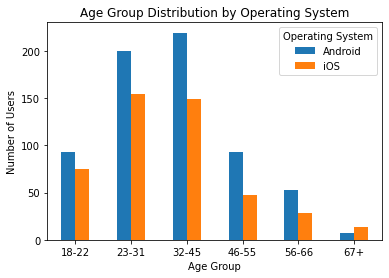

In [3]:
import matplotlib.pyplot as plt

plot_table = data_counts.drop(index="Total", errors="ignore") \
                          .drop(columns="Total", errors="ignore")

# Plot
plot_table.T.plot(
    kind="bar",
    figsize=(6,4)
)

plt.title("Age Group Distribution by Operating System")
plt.xlabel("Age Group")
plt.ylabel("Number of Users")
plt.xticks(rotation=0)
plt.legend(title="Operating System")
plt.show()

In [4]:
# % within Operating System (row-wise percent)
row_totals = data_counts.sum(axis=1)

percent_table = data_counts.div(row_totals, axis=0) * 100
percent_table = percent_table.round(1)

percent_table

,18-22,23-31,32-45,46-55,56-66,67+
Android,14.0,30.1,32.9,14.0,8.0,1.1
iOS,16.1,33.0,31.9,10.1,6.0,3.0


<font color="green">The percentage distribution shows that iOS users are slightly more concentrated in the younger age groups, while Android users have a somewhat higher proportion of users aged 32 and above. However, this difference is relatively small

#### Step 2: Create the contingency table

In [5]:
# Step 2: Create 2x2 contingency table

data_2x2 = pd.DataFrame({
    "Younger_than_32": younger_than_32,
    "Older_or_equal_32": older_or_equal_32
}, index=["Android", "iOS"])

data_2x2

,Younger_than_32,Older_or_equal_32
Android,293,372
iOS,229,238


#### Step 3.1: Perform Chi-Squared Test

Determine expected frequencies (E), chi-squared statistic (x<sup>2</sup>), degrees of freedom (k), critical value, and p-value

In [6]:
# Step 3: Chi-square test
chi2_stat, p_val, dof, expected = chi2_contingency(data_2x2)

# Step 4: Assess critical value
critical_value = chi2.ppf(0.95, dof)

print(f"\nChi-square statistic: {chi2_stat:.3f}")
print(f"Degrees of freedom (k): {dof}")
print(f"p-value: {p_val:.4f}")
print(f"Critical value (x{chr(178)}): {critical_value:.3f}")

if p_val < (1-0.95):
    print("Reject the null hypothesis: iOS and Android users differ by age group.")
else:
    print("Fail to reject the null hypothesis: no evidence iOS and Android users differ by age group.")


Chi-square statistic: 2.537
Degrees of freedom (k): 1
p-value: 0.1112
Critical value (x²): 3.841
Fail to reject the null hypothesis: no evidence iOS and Android users differ by age group.


#### Step 3.2: Visualizing the Chi-Square Distribution

Plot the **chi-square distribution**, highlighting:
- The **observed chi-square statistic**
- The **critical value**
- The **p-value area**

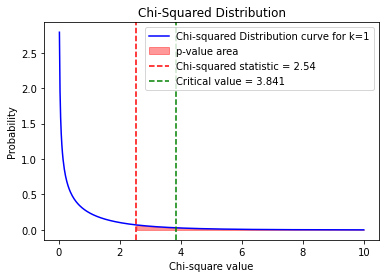

In [7]:
# Prepare x values for chi-square distribution plot
x_vals = np.linspace(0, 10, 500)
y_vals = chi2.pdf(x_vals, df=dof)

plt.plot(x_vals, y_vals, label=f'Chi-squared Distribution curve for k={dof}', color='blue')

# Shade the p-value tail (area where x >= observed chi-square)
plt.fill_between(x_vals, 0, y_vals, where=(x_vals >= chi2_stat), color='red', alpha=0.4, label='p-value area')

# Mark the observed chi-square statistic
plt.axvline(chi2_stat, color='red', linestyle='--', label=f'Chi-squared statistic = {chi2_stat:.2f}')

# Mark the critical value (the threshold for rejection)
plt.axvline(critical_value, color='green', linestyle='--', label=f'Critical value = {critical_value:.3f}')

plt.title('Chi-Squared Distribution')
plt.xlabel('Chi-square value')
plt.ylabel('Probability')
plt.legend()
plt.show()

<font color="green"> A chi-square test of independence examined whether age group (≤32 vs. >32) differs between iOS and Android users. The p-value was approximately 0.11, which is greater than α = 0.05, so the null hypothesis was not rejected. Therefore, this sample provides no statistically significant evidence that operating system is associated with being younger or older than 32 years.





## Step 4: Boot Strapping

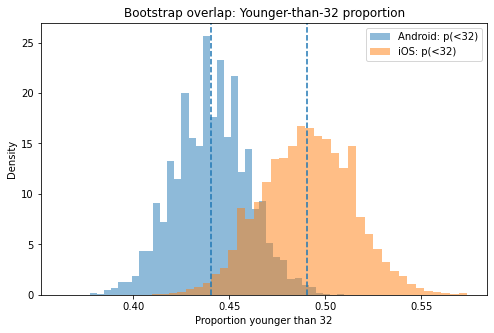

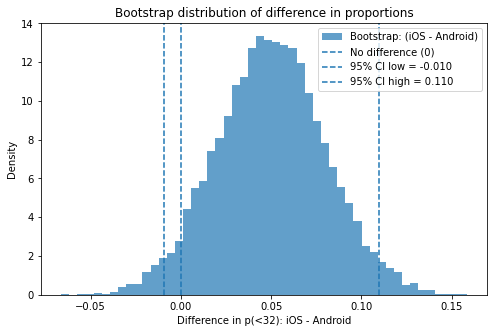

Android mean p(<32): 0.4406541353383459
iOS mean p(<32): 0.49051284796573874
Mean diff (iOS-Android): 0.04985871262739289
95% bootstrap CI for diff: [-0.010, 0.110]
Approx bootstrap p-value (two-sided): 0.0944


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Counts from your 2x2 table
android_y, android_o = 293, 372
ios_y, ios_o         = 229, 238

# Create individual-level arrays (1=younger, 0=older/equal)
android = np.array([1]*android_y + [0]*android_o)
ios     = np.array([1]*ios_y     + [0]*ios_o)

# Bootstrap
B = 10000
rng = np.random.default_rng(42)

boot_p_android = np.empty(B)
boot_p_ios = np.empty(B)

nA, nI = len(android), len(ios)

for b in range(B):
    sampA = rng.choice(android, size=nA, replace=True)
    sampI = rng.choice(ios, size=nI, replace=True)
    boot_p_android[b] = sampA.mean()
    boot_p_ios[b]     = sampI.mean()

# 1) Overlap plot: distributions of proportions (younger rate)
plt.figure(figsize=(8,5))
plt.hist(boot_p_android, bins=40, alpha=0.5, density=True, label="Android: p(<32)")
plt.hist(boot_p_ios,     bins=40, alpha=0.5, density=True, label="iOS: p(<32)")
plt.axvline(boot_p_android.mean(), linestyle="--")
plt.axvline(boot_p_ios.mean(),     linestyle="--")
plt.title("Bootstrap overlap: Younger-than-32 proportion")
plt.xlabel("Proportion younger than 32")
plt.ylabel("Density")
plt.legend()
plt.show()

# 2) Difference plot: iOS - Android
boot_diff = boot_p_ios - boot_p_android
ci_low, ci_high = np.percentile(boot_diff, [2.5, 97.5])

plt.figure(figsize=(8,5))
plt.hist(boot_diff, bins=50, alpha=0.7, density=True, label="Bootstrap: (iOS - Android)")
plt.axvline(0, linestyle="--", label="No difference (0)")
plt.axvline(ci_low, linestyle="--", label=f"95% CI low = {ci_low:.3f}")
plt.axvline(ci_high, linestyle="--", label=f"95% CI high = {ci_high:.3f}")
plt.title("Bootstrap distribution of difference in proportions")
plt.xlabel("Difference in p(<32): iOS - Android")
plt.ylabel("Density")
plt.legend()
plt.show()

print("Android mean p(<32):", boot_p_android.mean())
print("iOS mean p(<32):", boot_p_ios.mean())
print("Mean diff (iOS-Android):", boot_diff.mean())
print(f"95% bootstrap CI for diff: [{ci_low:.3f}, {ci_high:.3f}]")

# (Optional) bootstrap two-sided p-value style check:
p_boot = 2 * min((boot_diff <= 0).mean(), (boot_diff >= 0).mean())
print("Approx bootstrap p-value (two-sided):", p_boot)

To add bootstrapping, I repeatedly resampled the data (with replacement) many times and each time I calculated the proportion of users who are younger than 32 for Android and for iOS. This creates a distribution of possible proportions instead of using only one sample result.
Then I plotted the two bootstrap distributions on the same graph (overlap histogram). The Android and iOS distributions overlap a lot, which means their “younger than 32” proportions are very similar.


I also calculated the bootstrap distribution of the difference in proportions (iOS minus Android). On this graph, the vertical line at 0 represents “no difference.” Since 0 is inside the main range (and typically inside the 95% confidence interval), it suggests there is no strong evidence that iOS and Android differ by age group. This matches the chi-square test result (we fail to reject the null hypothesis).

We didn’t bootstrap the “older” group separately because it’s just the opposite of “younger.” In a 2-group table, Older (≥32) = 1 − Younger (<32), so bootstrapping older would give the same conclusion. We chose the younger proportion because it’s simpler to interpret and one category is enough to compare iOS vs Android.

Observed chi-square: 2.537349448665369


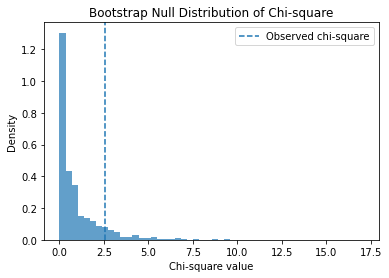

Bootstrap p-value: 0.1042


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# -----------------------
# Original observed table
# -----------------------
#           Young   Old
# Android    293    372
# iOS        229    238

obs_table = np.array([[293, 372],
                      [229, 238]])

# Real chi-square from data
chi2_obs, _, _, _ = chi2_contingency(obs_table)
print("Observed chi-square:", chi2_obs)

# -----------------------
# Prepare data for shuffling
# -----------------------
# OS labels (0 = Android, 1 = iOS)
os_labels = np.array([0]*(293+372) + [1]*(229+238))

# Age labels (1 = Young, 0 = Old)
age_labels = np.array([1]*293 + [0]*372 + [1]*229 + [0]*238)

# -----------------------
# Bootstrap under NULL
# -----------------------
B = 10000
rng = np.random.default_rng(42)
chi_boot = np.zeros(B)

for b in range(B):
    shuffled_age = rng.permutation(age_labels)  # break relationship

    # Rebuild table
    table = np.zeros((2,2))
    for os, age in zip(os_labels, shuffled_age):
        table[os, age] += 1

    chi_boot[b], _, _, _ = chi2_contingency(table)

# -----------------------
# Plot null distribution
# -----------------------
plt.hist(chi_boot, bins=50, density=True, alpha=0.7)
plt.axvline(chi2_obs, linestyle='--', label="Observed chi-square")
plt.title("Bootstrap Null Distribution of Chi-square")
plt.xlabel("Chi-square value")
plt.ylabel("Density")
plt.legend()
plt.show()

# -----------------------
# Bootstrap p-value
# -----------------------
p_boot = (chi_boot >= chi2_obs).mean()
print("Bootstrap p-value:", p_boot)


# Null Hypothesis Testing for College grad students

Null Hypothesis (H<sub>0</sub>): STEM vs. Non-STEM status is independent of graduate unemployment level (High vs. Low Grad_unemployment_rate)


S = Science
T = Technology
E = Engineering
M = Mathematics

In [10]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency,chi2
import matplotlib.pyplot as plt



####  Step 1: Upload and Explore data

In [11]:
%ls

 Volume in drive C is Windows-SSD
 Volume Serial Number is B482-BE92

 Directory of C:\Users\nazib\Assignments_UofT\MIE1624_DataScience

2026-01-25  01:58 PM    <DIR>          .
2026-01-17  08:21 PM    <DIR>          ..
2026-01-25  01:58 PM    <DIR>          .vscode
2026-01-07  07:04 PM    <DIR>          Lec1_Code
2026-01-21  12:16 PM    <DIR>          Lec3_Code
2026-02-02  06:48 PM    <DIR>          Presentation
               0 File(s)              0 bytes
               6 Dir(s)  55,069,429,760 bytes free


In [13]:
%pwd

'C:\\Users\\nazib\\Assignments_UofT\\MIE1624_DataScience'

In [14]:
df = pd.read_csv("Presentation/Data/grad-students.csv")
# df = pd.read_csv("content/grad-students.csv")

In [15]:
print("Shape:", df.shape)
print("Columns:", list(df.columns))
df.head()

Shape: (173, 22)
Columns: ['Major_code', 'Major', 'Major_category', 'Grad_total', 'Grad_sample_size', 'Grad_employed', 'Grad_full_time_year_round', 'Grad_unemployed', 'Grad_unemployment_rate', 'Grad_median', 'Grad_P25', 'Grad_P75', 'Nongrad_total', 'Nongrad_employed', 'Nongrad_full_time_year_round', 'Nongrad_unemployed', 'Nongrad_unemployment_rate', 'Nongrad_median', 'Nongrad_P25', 'Nongrad_P75', 'Grad_share', 'Grad_premium']


,Major_code,Major,Major_category,Grad_total,Grad_sample_size,Grad_employed,Grad_full_time_year_round,Grad_unemployed,Grad_unemployment_rate,Grad_median,...,Nongrad_total,Nongrad_employed,Nongrad_full_time_year_round,Nongrad_unemployed,Nongrad_unemployment_rate,Nongrad_median,Nongrad_P25,Nongrad_P75,Grad_share,Grad_premium
0,5601,CONSTRUCTION SERVICES,Industrial Arts & Consumer Services,9173,200,7098,6511,681,0.087543,75000.0,...,86062,73607,62435,3928,0.050661,65000.0,47000,98000.0,0.096320,0.153846
1,6004,COMMERCIAL ART AND GRAPHIC DESIGN,Arts,53864,882,40492,29553,2482,0.057756,60000.0,...,461977,347166,250596,25484,0.068386,48000.0,34000,71000.0,0.104420,0.250000
2,6211,HOSPITALITY MANAGEMENT,Business,24417,437,18368,14784,1465,0.073867,65000.0,...,179335,145597,113579,7409,0.048423,50000.0,35000,75000.0,0.119837,0.300000
3,2201,COSMETOLOGY SERVICES AND CULINARY ARTS,Industrial Arts & Consumer Services,5411,72,3590,2701,316,0.080901,47000.0,...,37575,29738,23249,1661,0.052900,41600.0,29000,60000.0,0.125878,0.129808
4,2001,COMMUNICATION TECHNOLOGIES,Computers & Mathematics,9109,171,7512,5622,466,0.058411,57000.0,...,53819,43163,34231,3389,0.072800,52000.0,36000,78000.0,0.144753,0.096154


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Major_code                    173 non-null    int64  
 1   Major                         173 non-null    object 
 2   Major_category                173 non-null    object 
 3   Grad_total                    173 non-null    int64  
 4   Grad_sample_size              173 non-null    int64  
 5   Grad_employed                 173 non-null    int64  
 6   Grad_full_time_year_round     173 non-null    int64  
 7   Grad_unemployed               173 non-null    int64  
 8   Grad_unemployment_rate        173 non-null    float64
 9   Grad_median                   173 non-null    float64
 10  Grad_P25                      173 non-null    int64  
 11  Grad_P75                      173 non-null    float64
 12  Nongrad_total                 173 non-null    int64  
 13  Nongr

#### Step 1.1: Check any duplicates or null entry

In [17]:
print("\nDuplicate rows:", df.duplicated().sum())
if "Major_code" in df.columns:
    print("Duplicate Major_code:", df["Major_code"].duplicated().sum())


Duplicate rows: 0
Duplicate Major_code: 0


In [18]:
nulls = df.isna().sum().sum()

if nulls == 0:
    print(" No missing (null) values in the dataset.")
else:
    print(f" Missing values found: {nulls} total.")
    display(df.isna().sum().loc[lambda s: s>0])


 No missing (null) values in the dataset.


#### Step 2: Create the contingency table

In [19]:
df["Major_category"].unique()

array(['Industrial Arts & Consumer Services', 'Arts', 'Business',
       'Computers & Mathematics', 'Law & Public Policy',
       'Agriculture & Natural Resources', 'Communications & Journalism',
       'Engineering', 'Social Science', 'Health', 'Interdisciplinary',
       'Physical Sciences', 'Humanities & Liberal Arts',
       'Psychology & Social Work', 'Biology & Life Science', 'Education'],
      dtype=object)

In [20]:


#  Create STEM vs Non-STEM (based on Major_category)
stem_categories = {
    "Engineering",
    "Computers & Mathematics",
    "Physical Sciences",
    "Biology & Life Science"
}

df["STEM_group"] = df["Major_category"].apply(
    lambda x: "STEM" if x in stem_categories else "Non-STEM"
)

# Convert Grad_unemployment_rate into a categorical variable (High/Low using median split)
threshold = df["Grad_unemployment_rate"].median()
df["Unemp_level"] = df["Grad_unemployment_rate"].apply(
    lambda x: "High" if x > threshold else "Low"
)

print("Median threshold for Grad_unemployment_rate:", threshold)


# Build 2x2 contingency table: STEM_group x Unemp_level
cont = pd.crosstab(df["STEM_group"], df["Unemp_level"])
print("\nContingency table (counts):")
display(cont)



Median threshold for Grad_unemployment_rate: 0.036654034

Contingency table (counts):


Unemp_level,High,Low
STEM_group,,
Non-STEM,63,46
STEM,23,41


#### Step 3: Perform Chi-Squared Test

Determine expected frequencies (E), chi-squared statistic (x2), degrees of freedom (k), critical value, and p-value

In [21]:
# Chi-square test of independence
chi2_stat, p_value, dof, expected = chi2_contingency(cont)

print("\nChi-square test results")
print("Chi-square statistic:",round(chi2_stat, 4))
print("p-value:",round(p_value, 4))
print("Degrees of freedom:", dof)


Chi-square test results
Chi-square statistic: 6.8587
p-value: 0.0088
Degrees of freedom: 1


<font color="green"> A chi-square test of independence showed a significant association between STEM group and unemployment level, p=0.0088.

#### Step 4: Visualizing the Chi-Square Distribution

Plot the **chi-square distribution**, highlighting:
- The **observed chi-square statistic**
- The **critical value**
- The **p-value area**

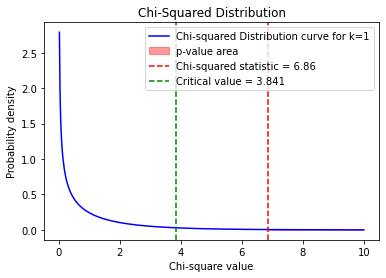

In [22]:
alpha = 0.05
critical_value = chi2.ppf(1 - alpha, dof)

# Prepare x values for chi-square distribution plot
x_vals = np.linspace(0, 10, 500)
y_vals = chi2.pdf(x_vals, df=dof)

plt.plot(x_vals, y_vals, label=f'Chi-squared Distribution curve for k={dof}', color='blue')

# Shade the p-value tail (area where x >= observed chi-square)
plt.fill_between(x_vals, 0, y_vals, where=(x_vals >= chi2_stat),
                 color='red', alpha=0.4, label='p-value area')

# Mark the observed chi-square statistic
plt.axvline(chi2_stat, color='red', linestyle='--', label=f'Chi-squared statistic = {chi2_stat:.2f}')

# Mark the critical value (the threshold for rejection)
plt.axvline(critical_value, color='green', linestyle='--', label=f'Critical value = {critical_value:.3f}')

plt.title('Chi-Squared Distribution')
plt.xlabel('Chi-square value')
plt.ylabel('Probability density')  # pdf is density
plt.legend()
plt.show()

# Question 2 P1: Comparing Two Distributions with Hypothesis Testing, Applied on iOS vs Android Users of 6 Age Groups


In [23]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install scipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
import pandas as pd
import numpy as np
from scipy import stats

count_data = {
    'Platform' : ['Android', 'Android', 'Android', 'Android', 'Android', 'Android',
                  'iOS', 'iOS', 'iOS', 'iOS', 'iOS', 'iOS'],
    'Age Group' : ['18-22', '23-31', '32-45', '46-55', '55-66', '67+',
                   '18-22', '23-31', '32-45', '46-55', '55-66', '67+',],
    'Count' : [93, 200, 219, 93, 53, 7,
               76, 154, 149, 47, 28, 14]
}

df = pd.DataFrame(count_data)

contingency_table = df.pivot_table(index='Platform', columns='Age Group', values='Count', aggfunc='sum')

column_order = ['18-22', '23-31', '32-45', '46-55', '55-66', '67+']
contingency_table = contingency_table[column_order]

print("Contingency Table: iOS vs Android Users by Age Group")
print(contingency_table)
print("\nRow Totals:")
print(f"  Android: {contingency_table.loc['Android'].sum()}")
print(f"iOS: {contingency_table.loc['iOS'].sum()}")
print(f"\nGrand Total: {contingency_table.sum().sum()}")




Contingency Table: iOS vs Android Users by Age Group
Age Group  18-22  23-31  32-45  46-55  55-66  67+
Platform                                         
Android       93    200    219     93     53    7
iOS           76    154    149     47     28   14

Row Totals:
  Android: 665
iOS: 468

Grand Total: 1133


In [25]:
row_totals = contingency_table.sum(axis=1)
col_totals = contingency_table.sum(axis=0)
grand_total = contingency_table.sum().sum()

expected = np.outer(row_totals, col_totals) / grand_total
expected_df = pd.DataFrame(
    expected,
    index=contingency_table.index,
    columns=contingency_table.columns
)

print("Expected Frequencies")
print(expected_df.round(2))


Expected Frequencies
Age Group  18-22   23-31   32-45  46-55  55-66    67+
Platform                                             
Android    99.19  207.78  215.99  82.17  47.54  12.33
iOS        69.81  146.22  152.01  57.83  33.46   8.67


In [26]:
chi2_stat, p_value, dof, expected_freq = stats.chi2_contingency(contingency_table)

print(f"\nChi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Degrees of Freedom: {dof}")

print(f"\nDegrees of Freedom Calculation:")
print(f"\n df (rows -1) x (columns - 1)")
print(f" df = ({contingency_table.shape[0] -1})  x  ({contingency_table.shape[1] -1})")
print(f" df = {contingency_table.shape[0] -1} x {contingency_table.shape[1] -1} = {dof}")


Chi-Square Test Results:
Chi-Square Statistic: 12.2844
P-value: 0.0311
Degrees of Freedom: 5

Degrees of Freedom Calculation:

 df (rows -1) x (columns - 1)
 df = (1)  x  (5)
 df = 1 x 5 = 5


In [27]:
print("Comparison: Observed vs Expected Frequencies")

print("\nObserved Frequencies:")
print(contingency_table)

print("\nExpected Frequencies:")
print(expected_df.round(2))

print("\nDifference (Observed - Expected):")
difference = contingency_table - expected_df
print(difference.round(2))


Comparison: Observed vs Expected Frequencies

Observed Frequencies:
Age Group  18-22  23-31  32-45  46-55  55-66  67+
Platform                                         
Android       93    200    219     93     53    7
iOS           76    154    149     47     28   14

Expected Frequencies:
Age Group  18-22   23-31   32-45  46-55  55-66    67+
Platform                                             
Android    99.19  207.78  215.99  82.17  47.54  12.33
iOS        69.81  146.22  152.01  57.83  33.46   8.67

Difference (Observed - Expected):
Age Group  18-22  23-31  32-45  46-55  55-66   67+
Platform                                          
Android    -6.19  -7.78   3.01  10.83   5.46 -5.33
iOS         6.19   7.78  -3.01 -10.83  -5.46  5.33


In [28]:
# Statistical decision at significance level alpha = 0.05
alpha = 0.05

print("Statistical Decision")
print("=" * 60)
print(f"Significance Level (alpha): {alpha}")
print(f"Chi-Square Statistic:       {chi2_stat:.4f}")
print(f"P-value:                    {p_value:.4f}")
print()

if p_value < alpha:
    print(f"Decision: REJECT the null hypothesis (p-value {p_value:.4f} < {alpha})")
else:
    print(f"Decision: FAIL TO REJECT the null hypothesis (p-value {p_value:.4f} >= {alpha})")

Statistical Decision
Significance Level (alpha): 0.05
Chi-Square Statistic:       12.2844
P-value:                    0.0311

Decision: REJECT the null hypothesis (p-value 0.0311 < 0.05)


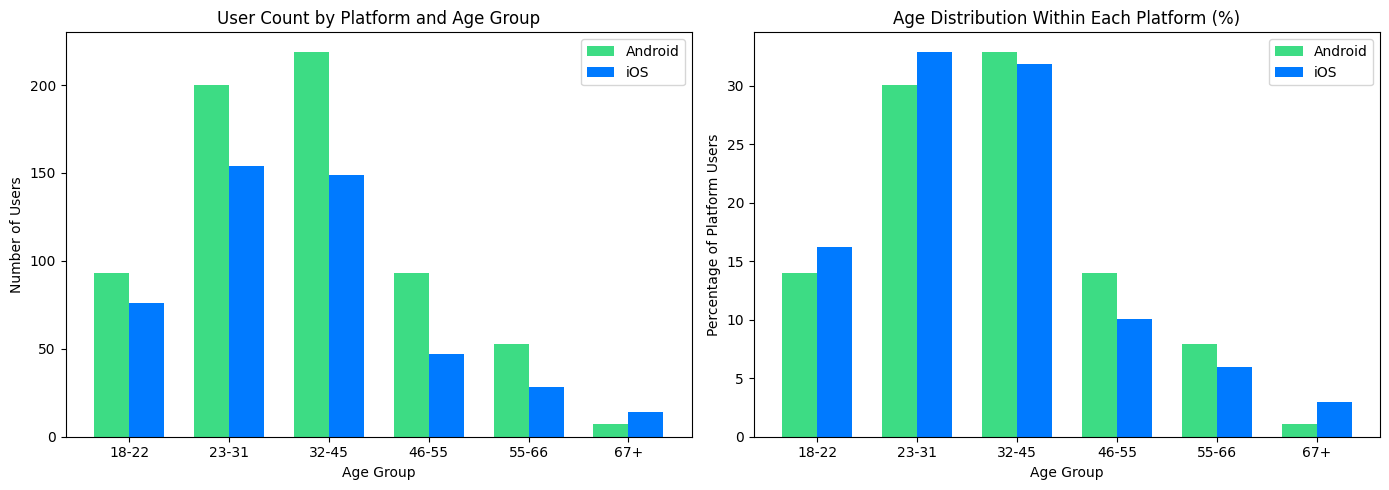

The percentage chart shows how the age distribution differs between platforms.


In [ ]:
import matplotlib.pyplot as plt

# Create side-by-side bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Absolute counts
x = np.arange(len(column_order))
width = 0.35

ax1 = axes[0]
ax1.bar(x - width/2, contingency_table.loc['Android'], width, label='Android', color='#3DDC84')
ax1.bar(x + width/2, contingency_table.loc['iOS'], width, label='iOS', color='#007AFF')
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Number of Users')
ax1.set_title('User Count by Platform and Age Group')
ax1.set_xticks(x)
ax1.set_xticklabels(column_order)
ax1.legend()

# Plot 2: Percentage distribution within each platform
android_pct = contingency_table.loc['Android'] / contingency_table.loc['Android'].sum() * 100
ios_pct = contingency_table.loc['iOS'] / contingency_table.loc['iOS'].sum() * 100

ax2 = axes[1]
ax2.bar(x - width/2, android_pct, width, label='Android', color='#3DDC84')
ax2.bar(x + width/2, ios_pct, width, label='iOS', color='#007AFF')
ax2.set_xlabel('Age Group')
ax2.set_ylabel('Percentage of Platform Users')
ax2.set_title('Age Distribution Within Each Platform (%)')
ax2.set_xticks(x)
ax2.set_xticklabels(column_order)
ax2.legend()

plt.tight_layout()
plt.show()

print("The percentage chart shows how the age distribution differs between platforms.")

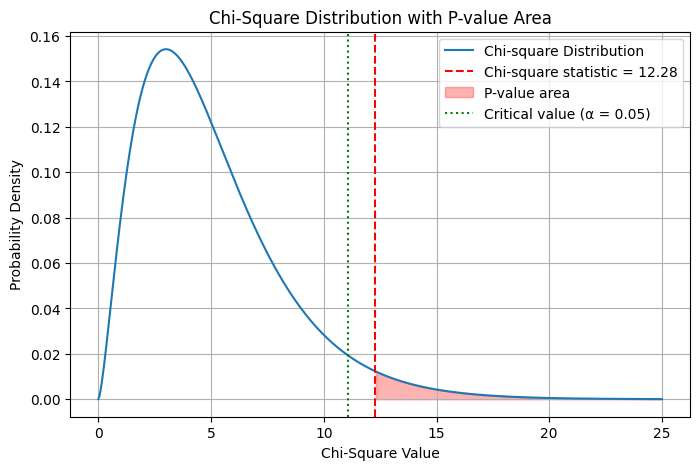

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

df = dof

x = np.linspace(0, df * 5, 500)
y = chi2.pdf(x, df)

plt.figure(figsize=(8, 5))
plt.plot(x, y, label='Chi-square Distribution')
plt.axvline(chi2_stat, linestyle='--', color='red', label=f'Chi-square statistic = {chi2_stat:.2f}')

# Shade the p-value area
x_pvalue = x[x >= chi2_stat]
y_pvalue = y[x >= chi2_stat]
plt.fill_between(x_pvalue, y_pvalue, color='red', alpha=0.3, label='P-value area')

plt.axvline(chi2.ppf(0.95, df), linestyle=':', color='green', label='Critical value (α = 0.05)')

plt.title('Chi-Square Distribution with P-value Area')
plt.xlabel('Chi-Square Value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

### Conclusion:
  There is a statistically significant association between
  platform choice (iOS vs Android) and age group.
  The distribution of users across age groups differs
  significantly between iOS and Android platforms.

# Q2P2: HYPOTHESES  
### H₀: The graduate employment rate distribution of the sample major category is the same as the overall population distribution.  
### H₁: The graduate employment rate of the sample major category is different from the overall population distribution.  

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chisquare
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, chi2


### Load Dataset

In [ ]:
df = pd.read_csv("grad-students.csv")

df.head()


,Major_code,Major,Major_category,Grad_total,Grad_sample_size,Grad_employed,Grad_full_time_year_round,Grad_unemployed,Grad_unemployment_rate,Grad_median,...,Nongrad_total,Nongrad_employed,Nongrad_full_time_year_round,Nongrad_unemployed,Nongrad_unemployment_rate,Nongrad_median,Nongrad_P25,Nongrad_P75,Grad_share,Grad_premium
0,5601,CONSTRUCTION SERVICES,Industrial Arts & Consumer Services,9173,200,7098,6511,681,0.087543,75000.0,...,86062,73607,62435,3928,0.050661,65000.0,47000,98000.0,0.096320,0.153846
1,6004,COMMERCIAL ART AND GRAPHIC DESIGN,Arts,53864,882,40492,29553,2482,0.057756,60000.0,...,461977,347166,250596,25484,0.068386,48000.0,34000,71000.0,0.104420,0.250000
2,6211,HOSPITALITY MANAGEMENT,Business,24417,437,18368,14784,1465,0.073867,65000.0,...,179335,145597,113579,7409,0.048423,50000.0,35000,75000.0,0.119837,0.300000
3,2201,COSMETOLOGY SERVICES AND CULINARY ARTS,Industrial Arts & Consumer Services,5411,72,3590,2701,316,0.080901,47000.0,...,37575,29738,23249,1661,0.052900,41600.0,29000,60000.0,0.125878,0.129808
4,2001,COMMUNICATION TECHNOLOGIES,Computers & Mathematics,9109,171,7512,5622,466,0.058411,57000.0,...,53819,43163,34231,3389,0.072800,52000.0,36000,78000.0,0.144753,0.096154


In [ ]:
# Create a new column
df["Grad_employment_rate"] = (1 - df["Grad_unemployment_rate"])*100
# Keep the columns we need
needed_cols = ["Major","Major_category", "Grad_unemployment_rate", "Grad_employment_rate"]
df = df[needed_cols]
df

,Major,Major_category,Grad_unemployment_rate,Grad_employment_rate
0,CONSTRUCTION SERVICES,Industrial Arts & Consumer Services,0.087543,91.245661
1,COMMERCIAL ART AND GRAPHIC DESIGN,Arts,0.057756,94.224415
2,HOSPITALITY MANAGEMENT,Business,0.073867,92.613321
3,COSMETOLOGY SERVICES AND CULINARY ARTS,Industrial Arts & Consumer Services,0.080901,91.909882
4,COMMUNICATION TECHNOLOGIES,Computers & Mathematics,0.058411,94.158937
...,...,...,...,...
168,COUNSELING PSYCHOLOGY,Psychology & Social Work,0.035600,96.440032
169,CLINICAL PSYCHOLOGY,Psychology & Social Work,0.044958,95.504197
170,HEALTH AND MEDICAL PREPARATORY PROGRAMS,Health,0.021687,97.831313
171,SCHOOL STUDENT COUNSELING,Education,0.051400,94.859970


In [ ]:
# A quick overview of how employment rates are distributed across all majors.
# Divided the employment rates into 10% intervals, from 0–10% to 90–100%
bins = list(range(0, 110, 10))
labels = [f"{i}-{i+10}%" for i in range(0, 100, 10)]

employment_rate = pd.cut(
    df["Grad_employment_rate"],
    bins=bins,
    labels=labels
)

Grad_employment_rate = employment_rate.value_counts().sort_index()

print(f"Employment Rate for Grads:\n{Grad_employment_rate}")

Employment Rate for Grads:
Grad_employment_rate
0-10%        0
10-20%       0
20-30%       0
30-40%       0
40-50%       0
50-60%       0
60-70%       0
70-80%       0
80-90%       2
90-100%    171
Name: count, dtype: int64


From the results, we can see that almost all employment rates were concentrated in the 90–100% range, and the rest ranges has 0 or very few counts.
Because these wide bins did not provide enough detail, we refined the bins and created four new categories within the 90–100% range.

In [ ]:
# Convert employment rate into 4 categories,so we can compare distributions
bins = [90, 93, 95, 97, 100]
labels = ["90–93%", "93–95%", "95–97%", "97–100%"]

df["Emp_level"] = pd.cut( df["Grad_employment_rate"],bins=bins,labels=labels,include_lowest=True, right=False)



### Population distribution

In [ ]:
# First,we try to caculate how many majors fall into each employment rate  for the full dataset

pop_counts = df["Emp_level"].value_counts().sort_index()


# Convert to proportions
pop_total = pop_counts.sum()
pop_props = pop_counts / pop_total

print("Population counts:")
print(pop_counts)
print("\nPopulation proportions:")
print(pop_props)

Population counts:
Emp_level
90–93%      9
93–95%     28
95–97%     74
97–100%    59
Name: count, dtype: int64

Population proportions:
Emp_level
90–93%     0.052941
93–95%     0.164706
95–97%     0.435294
97–100%    0.347059
Name: count, dtype: float64


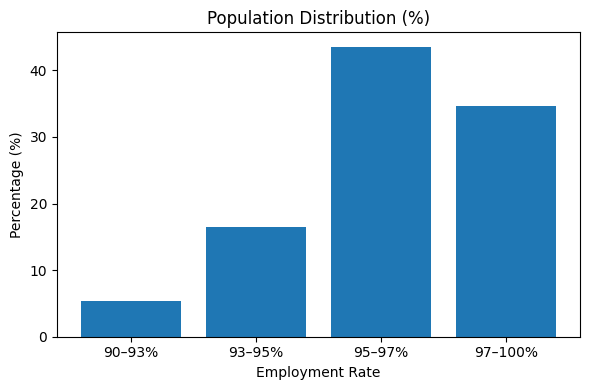

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.bar(pop_props.index, pop_props.values * 100)

ax.set_title("Population Distribution (%)")
ax.set_xlabel("Employment Rate")
ax.set_ylabel("Percentage (%)")

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### Sample distribution

In [ ]:
sample_category = "Engineering"

sample_df = df[df["Major_category"] == sample_category]["Emp_level"]

# Compute sample distribution across the same employment rate range

sample_counts = sample_df.value_counts().sort_index()


# Convert to proportions
sample_total = sample_counts.sum()
sample_props = sample_counts / sample_total
observed = sample_counts.to_numpy(dtype=float)

print("\nSample counts:")
print(sample_counts)
print("\nSample proportions:")
print(sample_props)



Sample counts:
Emp_level
90–93%      2
93–95%      5
95–97%     13
97–100%     9
Name: count, dtype: int64

Sample proportions:
Emp_level
90–93%     0.068966
93–95%     0.172414
95–97%     0.448276
97–100%    0.310345
Name: count, dtype: float64


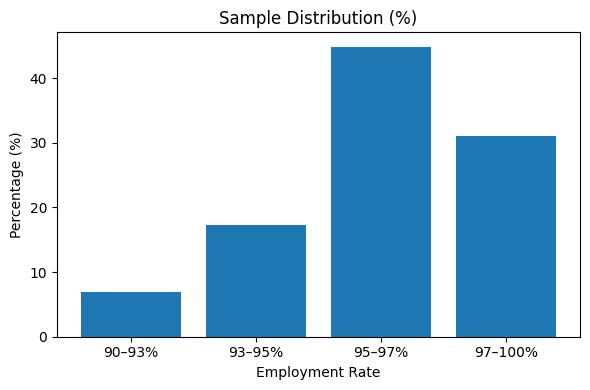

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.bar(sample_props.index, sample_props.values * 100)

ax.set_title("Sample Distribution (%)")
ax.set_xlabel("Employment Rate")
ax.set_ylabel("Percentage (%)")

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### Perform Chi-Squared Test

We perform chi-square goodness-of-fit test to check whether the category counts in our sample match what we would expect based on the population proportions, which helps us check whether the sample follows the same distribution as the population or if it is different.

In [ ]:
dof = len(sample_counts) - 1

expected = pop_props * sample_counts.sum()

chi2_stat, p = chisquare(f_obs=sample_counts,f_exp=expected)

print("Chi-square statistic:", chi2_stat)
print("p-value:", p)
print("Degrees of freedom:", dof)

Chi-square statistic: 0.27497736527543665
p-value: 0.9646637492869505
Degrees of freedom: 3


### Discussion

p-value = 0.965,which is ≥0.05, we fail to reject the null hypothesis. Sample employment distribution are statistically consistent with the overall population distribution.

Chi-square statistic = 0.275, which is very small, meaning the observed distribution of employment rate for Engineering majors is very close to the expected distribution based on the overall graduate population. In other words, there is very little difference between what we observed and what we would expect under the null hypothesis.

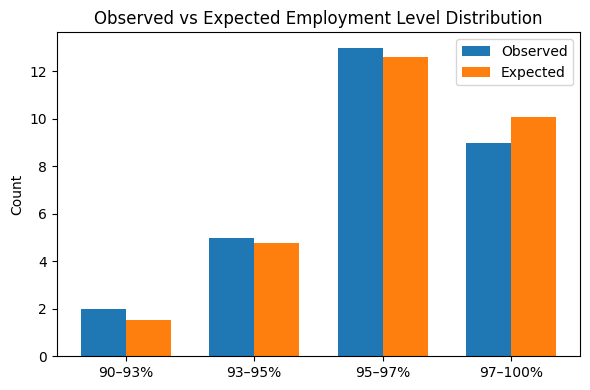

In [ ]:
categories = sample_counts.index

x = np.arange(len(categories))
width = 0.35

plt.figure(figsize=(6, 4))
plt.bar(x - width/2, sample_counts.values, width, label="Observed")
plt.bar(x + width/2, expected.values, width, label="Expected")

plt.xticks(x, categories)
plt.ylabel("Count")
plt.title("Observed vs Expected Employment Level Distribution")
plt.legend()
plt.tight_layout()
plt.show()

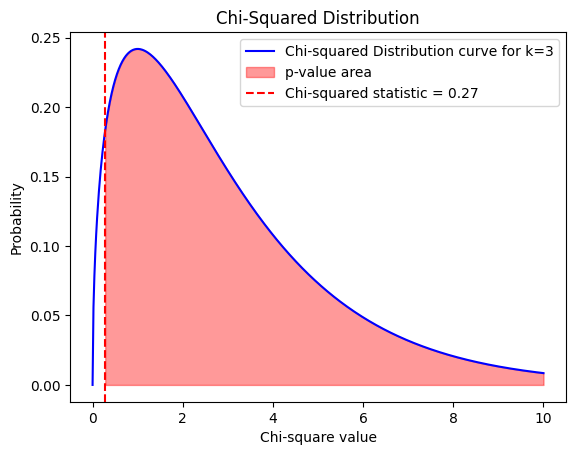

In [ ]:
# Prepare x values for chi-square distribution plot
x_vals = np.linspace(0, 10, 500)
y_vals = chi2.pdf(x_vals, df=dof)

plt.plot(x_vals, y_vals, label=f'Chi-squared Distribution curve for k={dof}', color='blue')

# Shade the p-value tail (area where x >= observed chi-square)
plt.fill_between(x_vals, 0, y_vals, where=(x_vals >= chi2_stat), color='red', alpha=0.4, label='p-value area')

# Mark the observed chi-square statistic
plt.axvline(chi2_stat, color='red', linestyle='--', label=f'Chi-squared statistic = {chi2_stat:.2f}')


plt.title('Chi-Squared Distribution')
plt.xlabel('Chi-square value')
plt.ylabel('Probability')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Flag for in Colab environment or not
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

print(IN_COLAB)

False


# Question 3

In [ ]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')


In [ ]:
%pwd

'c:\\Users\\nazib\\Assignments_UofT\\MIE1624_DataScience\\Presentation'

In [ ]:
%ls Presentation\Data

The system cannot find the file specified.


In [ ]:
file_path = 'anes_timeseries_2020_csv_20220210/anes_timeseries_2020_csv_20220210.csv'

In [ ]:
# Data Importing

import pandas as pd
import os

if IN_COLAB:
    from google.colab import drive


    # Mount Google Drive
    drive.mount('/content/drive')

    # Set your file path
    file_path = "/content/drive/MyDrive/anes_timeseries_2020_csv.csv"

    df_anes = pd.read_csv(file_path)
    print(df_anes.head(5))

else:  # Local / Github
    file_path = file_path
    df_anes = pd.read_csv(file_path)
    print(df_anes.head(5))


                       version  V200001  V160001_orig  V200002  V200003  \
0  ANES2020TimeSeries_20220210   200015        401318        3        2   
1  ANES2020TimeSeries_20220210   200022        300261        3        2   
2  ANES2020TimeSeries_20220210   200039        400181        3        2   
3  ANES2020TimeSeries_20220210   200046        300171        3        2   
4  ANES2020TimeSeries_20220210   200053        405145        3        2   

   V200004  V200005  V200006  V200007  V200008  ...  \
0        3        0       -2       -2       -2  ...   
1        3        0        4       -1        3  ...   
2        3        0       -2       -2       -2  ...   
3        3        0       -2       -2       -2  ...   
4        3        1       -2       -2       -2  ...   

                        V203518  V203519           V203520  V203521  V203522  \
0     Thomas Jeffery 'Tom' Cole        1  -1. Inapplicable       -1       -1   
1  Michael Keith 'Mike' Simpson        1  -1. Inapplicable

C:\Users\nazib\AppData\Local\Temp\ipykernel_33476\2130285153.py:21: DtypeWarning: Columns (15,17,18,19,21,22,23,25,26,27,29,30,31,33,34,35,37,38,1508,1509) have mixed types. Specify dtype option on import or set low_memory=False.
  df_anes = pd.read_csv(file_path)


## Pre-processing & Selecting Columns

In [ ]:
# -----------------------------
# DEFINE VARIABLES TO USE
# -----------------------------

# Sex variable
sex = 'V201600'          # 1 = Male, 2 = Female

# Political party affiliation variable
party_ID = 'V201231x'       # Democrat / Republican / Independent

# Immigration status / attitude variable
immigration_opinion = 'V202232'  #
#V202232
# What should Immigration Levels be?
immigration_citizenship_opinion = 'V202244'
#V202244
#Path to citizenship, attitude


In [ ]:
# Select only the chosen variables
df_election = df_anes[[sex, party_ID, immigration_opinion, immigration_citizenship_opinion]]

# Rename columns for clarity
df_election.columns = ['Sex', 'Party', 'Immigration_Opinion', 'Immigration_Citizenship_Opinion']


In [ ]:
# Missing Values
# ANES Encoding Reference
#  -9 = Missing;
#  -8 = Don't know;
#  -7 = Refused;
#  -1 = Inapplicable

# Clean out these missing values (remove any negative values)
df_election = df_election[(df_election >= 0).all(axis=1)]  # axis = 1 returns Rows where ALL values are >= 0
# Only keep rows where all values are >= 0

#df_election[(df_election < 0).any(axis=1)]  # Check that there are no negative values left

df_election.head()

,Sex,Party,Immigration_Opinion,Immigration_Citizenship_Opinion
0,1,7,4,1
2,2,3,1,1
3,1,6,3,2
4,1,4,5,2
5,2,3,3,2


In [ ]:
df_election.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5181 entries, 0 to 8279
Data columns (total 4 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   Sex                              5181 non-null   int64
 1   Party                            5181 non-null   int64
 2   Immigration_Opinion              5181 non-null   int64
 3   Immigration_Citizenship_Opinion  5181 non-null   int64
dtypes: int64(4)
memory usage: 202.4 KB


In [ ]:
print("Sex categories:\n", df_election['Sex'].value_counts())
print("\nParty categories:\n", df_election['Party'].value_counts())
print("\nImmigration categories:\n", df_election['Immigration_Opinion'].value_counts())
#print("\nImmigration Citizenship categories:\n", df_election['Immigration_Citizenship_Opinion'].value_counts())


Sex categories:
 2    2748
1    2433
Name: Sex, dtype: int64

Party categories:
 1    1332
7    1143
3     626
2     545
5     518
6     513
4     504
Name: Party, dtype: int64

Immigration categories:
 3    1869
2    1106
5     770
4     722
1     714
Name: Immigration_Opinion, dtype: int64


In [ ]:
# Decoding the Values

# Keep only party codes we care about
valid_party_codes = [1, 2, 3, 4, 5, 6, 7]
df_election = df_election[df_election['Party'].isin(valid_party_codes)]

# Recode party ID
def recode_party(p):
    """
    Recode ANES party identification codes into consolidated party categories.
    (PRE)
    a.	V201231x - Party Identification

    This function is designed to be applied element-wise to a pandas Series
    using `Series.apply()` or `DataFrame.apply()`. When used with
    `df['Party'].apply(recode_party)`, the function is called once for each
    row value in the 'Party' column, and the returned value replaces the
    original party code for that row.

    Mapping:
    - 1  -> 1  (Democrat)
    - 7  -> 7  (Republican)
    - 4  -> 4  (Independent)
    - 2, 3, 5, 6 -> 11 (Swing / Other)

    Parameters
    ----------
    p : int
        Original ANES party identification code.

    """
    if p == 1:
        return "Democrat"      # Democrat
    elif p == 7:
        return "Republican"      # Republican
    elif p == 4:
        return "Independent"      # Independent
    else:
        return "Swing"     # Swing

df_election['Party'] = df_election['Party'].apply(recode_party)

In [ ]:
# Decode Sex categories
def recode_sex(s:int) -> str:
    """
    Recode ANES sex codes into string labels.
    (PRE)
    Mapping
    - 1 -> 'Male'
    - 2 -> 'Female'

    Will work with pandas.Series.apply()
    calling Series.apply(recode_sex) will apply this function to each element in the Series, and hence replace the values with
    the return values accordingly.
    """
    if s == 1:
        return "Male"
    elif s == 2:
        return "Female"

df_election['Sex'] = df_election['Sex'].apply(recode_sex)


In [ ]:
# Decode Immigration Level Opinion

"""
Recodes ANES Survey Question
(POST)
V202232:

ANES Survey Question
What should Immigration Levels be?
- 1 = Increase a lot
- 2 = Increase a little
- 3 = Keep the same
- 4 = Decrease a little
- 5 = Decrease a lot
"""

# def recode_immigration_opinion(io:int) -> str:
#     """
#     For Pandas Series.apply() usage.

#     Mapping:
#     - 1 -> 'Increase a lot'
#     - 2 -> 'Increase a little'
#     - 3 -> 'Keep the same'
#     - 4 -> 'Decrease a little'
#     - 5 -> 'Decrease a lot'
#     """
#     if io == 1:
#         return "Increase a lot"
#     elif io == 2:
#         return "Increase a little"
#     elif io == 3:
#         return "Keep the same"
#     elif io == 4:
#         return "Decrease a little"
#     elif io == 5:
#         return "Decrease a lot"

# df_election['Immigration_Opinion'] = df_election['Immigration_Opinion'].apply(recode_immigration_opinion)

'\nRecodes ANES Survey Question\n(POST) \nV202232:\n\nANES Survey Question \nWhat should Immigration Levels be?\n- 1 = Increase a lot\n- 2 = Increase a little\n- 3 = Keep the same\n- 4 = Decrease a little\n- 5 = Decrease a lot\n'

In [ ]:
# Viewing the Categories.
print("Sex categories:\n", df_election['Sex'].value_counts())
print("\nParty categories:\n", df_election['Party'].value_counts())
print("\nImmigration categories:\n", df_election['Immigration_Opinion'].value_counts())

Sex categories:
 Female    2748
Male      2433
Name: Sex, dtype: int64

Party categories:
 Swing          2202
Democrat       1332
Republican     1143
Independent     504
Name: Party, dtype: int64

Immigration categories:
 3    1869
2    1106
5     770
4     722
1     714
Name: Immigration_Opinion, dtype: int64


## Chi-Squared Test of Association

### Contingency Table Formation

In [ ]:
df_election = df_election.dropna()
df_election.head()


,Sex,Party,Immigration_Opinion,Immigration_Citizenship_Opinion
0,Male,Republican,4,1
2,Female,Swing,1,1
3,Male,Swing,3,2
4,Male,Independent,5,2
5,Female,Swing,3,2


In [ ]:
contingency_table1 = pd.crosstab(
    [df_election['Sex'], df_election['Immigration_Opinion']],
    df_election['Party'],
)

contingency_table1


Party                       Democrat  Independent  Republican  Swing
Sex    Immigration_Opinion                                          
Female 1                         219           25          15    145
       2                         286           53          24    231
       3                         256          101         189    419
       4                          49           30         145    155
       5                          35           41         185    145
Male   1                         131           25          16    138
       2                         181           42          23    266
       3                         129          114         234    427
       4                          32           29         137    145
       5                          14           44         175    131

For Immigration Opinion

```python
'''
ANES Survey Question
What should Immigration Levels be?
     1 = Increase a lot
     2 = Increase a little
     3 = Keep the same
     4 = Decrease a little
     5 = Decrease a lot
'''
```

### Null Hypothesis

**Hypothesis H_0**:
Sex, immigration opinion, and political party affiliation are mutually independent

**Alternative Hypothesis (H_1):**
At least one association exists among sex, immigration opinion, and political party affiliation.

In [ ]:
# Chi-Squared Test of Independence (Contingency Table 1)
chi2_1, p_1, dof_1, expected_1 = chi2_contingency(contingency_table1)

print("Chi-squared Test Results for Contingency Table 1:")
print(f"Chi2 Statistic: {chi2_1}")

print(f"Degrees of Freedom: {dof_1}")

print(f"P-value: {p_1}")

# Decision to reject or fail to reject null hypothesis
alpha = 0.05
if p_1 < alpha:
    print("Reject the null hypothesis: There is a significant association between the variables.")
else:
    print("Fail to reject the null hypothesis: Insufficient Evidence of an association between the variables.")




Chi-squared Test Results for Contingency Table 1:
Chi2 Statistic: 1143.302934369328
Degrees of Freedom: 27
P-value: 9.451800688120278e-224
Reject the null hypothesis: There is a significant association between the variables.


**Reject** the hypothesis, there is significant association between variables. Sex, immigration opinion, and political party affiliation are NOT mutually independent

Since we found association between variables, lets do the heatmap

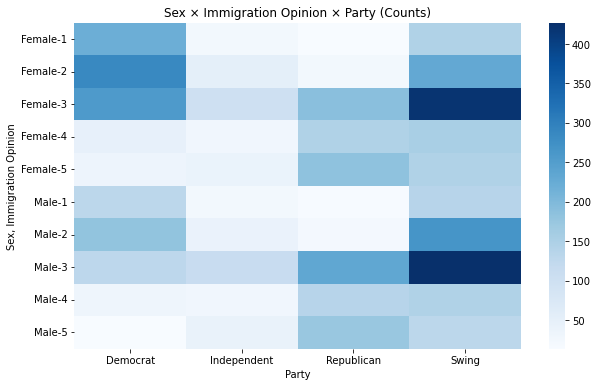

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table1, annot=False, cmap="Blues")
plt.title("Sex × Immigration Opinion × Party (Counts)")
plt.xlabel("Party")
plt.ylabel("Sex, Immigration Opinion")
plt.show()

Interpretation from Heat Map:
View on immigration differs with Political party idenity for both Male and Female groups. Male and female groups show similar pattern in all political party values, Males and Females within each party have similar views on immigration opinion, except for the Democart party (Females in Democart party are more in favor of increasing immigration than Males in the same party).

It suggest that Political party variable influences the Immigration opinion variable. There is strong evidence to find association between these two variables.

**Conclusion:** We can hypothesize variables `Party` and `Immigration_Opinion` may be **dependent**.

For the next step. we will do a pair-wise test of independence, taking two variables at a time. This time we will account for ordinal value of `Immigration_opinion` column. (not reflected in Chi-Squared test)

## Further Pairwise Test

### Party x Immigration Opinion (Kruskal-Wallis Test)

For the **Kruskal Wallis Test**.

* Groups -> `Party`
* Outcome -> `Immigration_Opinion`

**Null hypothesis (H_0):**
The distribution of immigration opinions is the same across all political party groups.

Equivalently:

The median immigration opinion does not differ by party affiliation

**Alternative Hypothesis (H_1):**
At least one political party group has a different distribution of immigration opinions. (This does not say which party — only that a difference exists.)

In [ ]:
# Kruskal-Wallis H Test
# Party x Immigraion_Opinion

from scipy.stats import kruskal

groups = [
    df_election[df_election['Party'] == party]['Immigration_Opinion']
    for party in df_election['Party'].unique()
]

h_stat, p_value = kruskal(*groups)

print(f"Kruskal-Wallis H Test result: \nH-statistic = {h_stat}, \np-value = {p_value}")

Kruskal-Wallis H Test result: 
H-statistic = 996.8456449007408, 
p-value = 8.697763399488002e-216


What this means:

number of party groups = 4

Degrees of freedom = 𝑔−1 =3

Reference distribution = $\chi^2_{3}$

	​
A value of `h = 996.85`  on a $\chi^2_{3}$ distribution lies **astronomically far in the right tail**.

That is why the p-value is so small (`8.69e-216`) .

So we say:

The probability of observing an H value at least this large under the null hypothesis is very small. This probability is the **p-value**

$$P(\chi^2_{g-1} \ge H_{\text{observed}})$$

`p_value < 0.05`: **Reject Null Hypothesis**

**Conclusion:** The distribution of immigration opinions is NOT the same across all political party groups. At least one political party group has a different distribution of immigration opinions. (This does not say which party — only that a difference exists.)

Kruskal–Wallis H statistic: 996.846
Degrees of freedom (g - 1): 3
p-value: 8.698e-216
Critical value (α = 0.05): 7.815
Reject the null hypothesis: Immigration opinion differs by party affiliation.


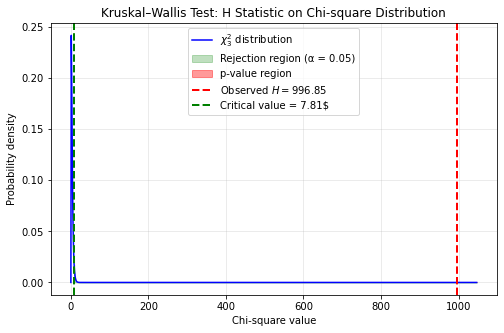

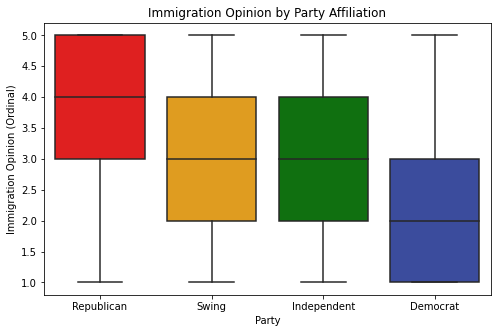

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(
    x='Party',
    y='Immigration_Opinion',
    data=df_election,
    palette=['red', 'orange', 'green', '#2b41ad']
)
plt.title('Immigration Opinion by Party Affiliation')
plt.xlabel('Party')
plt.ylabel('Immigration Opinion (Ordinal)')
plt.show()

We can see different median values on the immigration opinion scale (1 means most in favor of immigration, 5 means lest in favor of immigration). There is a signinficant difference in opinion between Republican and Democrat parties (not surprising)

A Kruskal–Wallis test was used to compare ordinal immigration opinions across political parties. The test statistic (H = 996.85, p < 0.05) indicates strong evidence that immigration opinion distributions differ by party affiliation. Means variables `Immigration_Opinion` and `Party` may be dependent. Boxplots and rank-based visualizations confirm systematic differences in central tendency and distribution shape across parties

### Sex x Immigration Opinion (Kruskal-Wallis Test)

Let's see if Krusal-Wallis Test can find similar difference in distribution of Immigration opinion according to sex.

* Groups -> `Sex`
* Outcome -> `Immigration_Opinion`

**Null hypothesis (H_0):**
The distribution of immigration opinions is the same across all sex groups.

Equivalently:

The median immigration opinion does not differ by sex

**Alternative Hypothesis (H_1):**
At least one sex has a different distribution of immigration opinions. (This does not say which sex — only that a difference exists.)

In [ ]:
# Kruskal-Wallis H Test
# Sex x Immigraion_Opinion

from scipy.stats import kruskal

groups = [
    df_election[df_election['Sex'] == sex]['Immigration_Opinion']
    for sex in df_election['Sex'].unique()
]

h_stat, p_value = kruskal(*groups)

print(f"Kruskal-Wallis H Test result: \nH-statistic = {h_stat}, \np-value = {p_value}")

Kruskal-Wallis H Test result: 
H-statistic = 2.470302107810458, 
p-value = 0.11601562360400228


p-value is not small enough (p_value > ($\alpha = 0.05$))

There is a high probability of finding this H value in the $\chi^2_1$ distribution. Which means that no correlation exists between sex and immigration opinion, and the only discrepancies we find in distribution of immigration opinion among sex groups is highly likely due to noise, and not due to association between the two variables.

**FTR:** Fail to Reject the Null Hypothesis; The distribution of immigration opinions is the same across all sex groups

**Conculsion:** Sex DOES NOT influences Immigration opinion. (Not enough evidence we have that Sex influences Immigration Opinion)
Variables `Sex` and `Immigration Opinion` are Independent

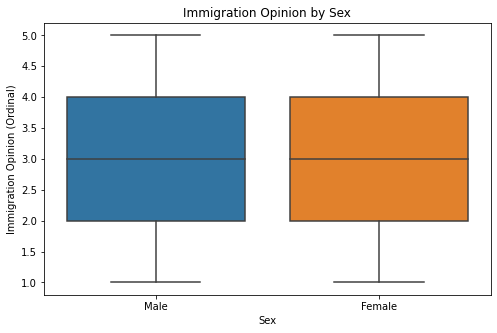

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(
    x='Sex',
    y='Immigration_Opinion',
    data=df_election,
)
plt.title('Immigration Opinion by Sex')
plt.xlabel('Sex')
plt.ylabel('Immigration Opinion (Ordinal)')
plt.show()

Box plot also confirms that the median immigration opinion is very close for both sex groups

Kruskal–Wallis H statistic: 2.470
Degrees of freedom (g - 1): 3
p-value: 1.160e-01
Critical value (α = 0.05): 7.815
Fail to reject the null hypothesis: No evidence of party differences.


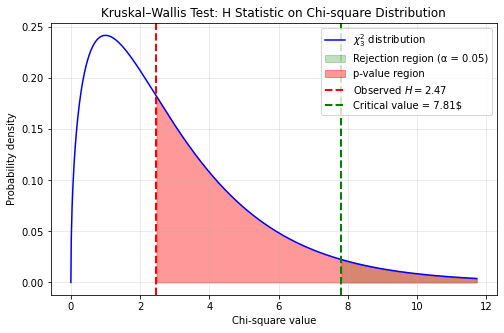

In [ ]:
# # Plot the Chi-square Distribution with H Statistic and p-value

# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import chi2

# # Given from Kruskal–Wallis test
# H_stat = h_stat
# p_val = p_value

# # Number of groups and degrees of freedom
# g = df_election['Party'].nunique()
# dof = g - 1

# # Significance level
# alpha = 0.05

# # Critical value from chi-square distribution
# critical_value = chi2.ppf(1 - alpha, dof)

# print(f"Kruskal–Wallis H statistic: {H_stat:.3f}")
# print(f"Degrees of freedom (g - 1): {dof}")
# print(f"p-value: {p_val:.3e}")
# print(f"Critical value (α = {alpha}): {critical_value:.3f}")

# if p_val < alpha:
#     print("Reject the null hypothesis: Immigration opinion differs by party affiliation.")
# else:
#     print("Fail to reject the null hypothesis: No evidence of party differences.")

# # Range for chi-square distribution
# x_max = max(critical_value * 1.5, H_stat * 1.05)
# x_vals = np.linspace(0, x_max, 1000)
# y_vals = chi2.pdf(x_vals, df=dof)

# # Plot chi-square distribution
# plt.figure(figsize=(8, 5))
# plt.plot(
#     x_vals,
#     y_vals,
#     label=rf'$\chi^2_{{{dof}}}$ distribution',
#     color='blue'
# )

# # Shade rejection region (x ≥ critical value)
# plt.fill_between(
#     x_vals,
#     0,
#     y_vals,
#     where=(x_vals >= critical_value),
#     color='green',
#     alpha=0.25,
#     label='Rejection region (α = 0.05)'
# )

# # Shade p-value region (x ≥ observed H)
# plt.fill_between(
#     x_vals,
#     0,
#     y_vals,
#     where=(x_vals >= H_stat),
#     color='red',
#     alpha=0.4,
#     label='p-value region'
# )

# # Mark observed H statistic
# plt.axvline(
#     H_stat,
#     color='red',
#     linestyle='--',
#     linewidth=2,
#     label=rf'Observed $H = {H_stat:.2f}$'
# )

# # Mark critical value
# plt.axvline(
#     critical_value,
#     color='green',
#     linestyle='--',
#     linewidth=2,
#     label=rf'Critical value = {critical_value:.2f}$'
# )

# plt.title('Kruskal–Wallis Test: H Statistic on Chi-square Distribution')
# plt.xlabel('Chi-square value')
# plt.ylabel('Probability density')
# plt.legend()
# plt.grid(alpha=0.3)
# plt.show()


Chi-square Distribution visualizing our **Fail to Reject** decision since p-value region is much much greater than Rejection region at our significance level ($\alpha = 0.05$)

### Sex x Immigration Opinion (Mann- Whitney Test)

Alternatively we can do the Mann-Whitney Test for similar hypothesis testing, because `Sex` variable has only two categorical values

In [ ]:
# Man Whitney U Test
from scipy.stats import mannwhitneyu

male_opinion = df_election[df_election['Sex'] == 'Male']['Immigration_Opinion']
female_opinion = df_election[df_election['Sex'] == 'Female']['Immigration_Opinion']

u_stat, p_value = mannwhitneyu(male_opinion, female_opinion, alternative='two-sided')

print(u_stat, p_value)

3424591.5 0.11601785674185876


Mann–Whitney U statistic: 3424591.5
Z statistic: 1.520
p-value: 0.1160
Critical Z values (±z_α/2): ±1.960
Fail to reject the null hypothesis: No evidence of sex differences.


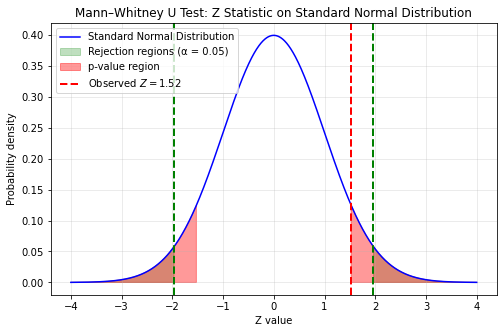

In [ ]:
# Plot for the Mann-Whitney U Test
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Given from Mann–Whitney U test
U_stat = u_stat
p_val = p_value

# Sample sizes
n1 = len(male_opinion)
n2 = len(female_opinion)

# Mean and standard deviation of U under H0
mu_U = n1 * n2 / 2
sigma_U = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)

# Z-statistic (normal approximation)
Z_stat = (U_stat - mu_U) / sigma_U

# Significance level
alpha = 0.05

# Critical Z values (two-sided test)
z_crit = norm.ppf(1 - alpha / 2)

print(f"Mann–Whitney U statistic: {U_stat:.1f}")
print(f"Z statistic: {Z_stat:.3f}")
print(f"p-value: {p_val:.4f}")
print(f"Critical Z values (±z_α/2): ±{z_crit:.3f}")

if p_val < alpha:
    print("Reject the null hypothesis: Immigration opinions differ by sex.")
else:
    print("Fail to reject the null hypothesis: No evidence of sex differences.")

# Range for standard normal distribution
x_vals = np.linspace(-4, 4, 1000)
y_vals = norm.pdf(x_vals)

# Plot standard normal distribution
plt.figure(figsize=(8, 5))
plt.plot(x_vals, y_vals, color='blue', label='Standard Normal Distribution')

# Shade rejection regions
plt.fill_between(
    x_vals,
    0,
    y_vals,
    where=(np.abs(x_vals) >= z_crit),
    color='green',
    alpha=0.25,
    label='Rejection regions (α = 0.05)'
)

# Shade p-value region
plt.fill_between(
    x_vals,
    0,
    y_vals,
    where=(np.abs(x_vals) >= abs(Z_stat)),
    color='red',
    alpha=0.4,
    label='p-value region'
)

# Mark observed Z statistic
plt.axvline(
    Z_stat,
    color='red',
    linestyle='--',
    linewidth=2,
    label=rf'Observed $Z = {Z_stat:.2f}$'
)

# Mark critical Z values
plt.axvline(z_crit, color='green', linestyle='--', linewidth=2)
plt.axvline(-z_crit, color='green', linestyle='--', linewidth=2)

plt.title('Mann–Whitney U Test: Z Statistic on Standard Normal Distribution')
plt.xlabel('Z value')
plt.ylabel('Probability density')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Same outcome as Krusal-Wallis Test, Fail to reject Null hypothesis. Same p-value as well.

**Conculsion:** Sex DOES NOT influences Immigration opinion. (Not enough evidence that Sex influences Immigration Opinion)
Variables `Sex` and `Immigration Opinion` are Independent

### Sex x Political Party Affliation (Chi-Squared Test)

No Ordinal data here, so we can do Chi-squared Test of association

In [ ]:
# Sex x Party
ct_sp = pd.crosstab(
    df_election['Sex'],
    df_election['Party']
)
ct_sp

Party,Democrat,Independent,Republican,Swing
Sex,,,,
Female,845,250,558,1095
Male,487,254,585,1107


Significantly more Female Democrats than Male Democrats

In [ ]:
chi2_sp, p_sp, dof_sp, exp_sp = chi2_contingency(ct_sp)

print("Sex × Party")
print(f"Chi-square statistic: {chi2_sp:.3f}")
print(f"Degrees of freedom: {dof_sp}")
print(f"P-value: {p_sp:.6f}")

if p_sp < 0.05:
    print("Reject the null hypothesis: There is a significant association between variables.")
else:
    print("Fail to reject the null hypothesis: Insufficient Evidence of an association between the variables.")

Sex × Party
Chi-square statistic: 78.091
Degrees of freedom: 3
P-value: 0.000000
Reject the null hypothesis: There is a significant association between variables.


**Conclusion:** Sex does influence political party association. Variables `Sex` and `Party` are dependent

All parties have very different views on immigration

### Conclusion on Dataset:

1. **Chi-squared Test of association on N-dimensions:** there is significant association at least between a pair among the variables - `Sex`, `Immigration_Opinion`, and `Party`. Not all the variables are NOT mutually independent.

**Further Pairwise Test Results:**

1. **Party x Immigration Opinion:** The distribution of immigration opinions is NOT the same across all political party groups. At least one political party group has a different distribution of immigration opinions. (This does not say which party — only that a difference exists.) **(Kruskal- Wallis Test)**

2. **Sex x Immigration Opinion** Sex DOES NOT influences Immigration opinion. (Not enough evidence we have that Sex influences Immigration Opinion)
Variables `Sex` and `Immigration Opinion` are Independent **(Mann-Whitney Test)**

3. **Sex x Political Party Affiliation:** Sex does influence political party association. Variables `Sex` and `Party` are dependent **(Chi-Squared Test)**

# Additional Material:
------------------------

## Ordinal Logistic Regression:

Ordinal Logistic regression trains a Machine Learning model to fit a probability distribution within the ordinal data for each category.

Since the variable `Immigration_Opinion` has an ordinal value whereas all other variables (`Sex`, `Party`) are purely categorial, we use the **Ordinal Logistic Regression** method to estimates how Sex and Party shift respondents toward higher or lower immigration-restriction categories, while respecting the ordinality of the `Immigration_Opinion` column.


### Results

In [ ]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

model = OrderedModel(
    df_election['Immigration_Opinion'],
    pd.get_dummies(df_election[['Sex', 'Party']], drop_first=True),
    distr='logit'
)

result = model.fit(method='bfgs')
print(result.summary())

Optimization terminated successfully.
         Current function value: 1.425160
         Iterations: 29
         Function evaluations: 31
         Gradient evaluations: 31
                              OrderedModel Results                             
Dep. Variable:     Immigration_Opinion   Log-Likelihood:                -7383.8
Model:                    OrderedModel   AIC:                         1.478e+04
Method:             Maximum Likelihood   BIC:                         1.484e+04
Date:                 Tue, 27 Jan 2026                                         
Time:                         00:02:41                                         
No. Observations:                 5181                                         
Df Residuals:                     5173                                         
Df Model:                            8                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
----------------------

This is an ordinal logistic regression (proportional odds model) with:

Outcome (ordered):

`Immigration_Opinion`

(1 = Increase a lot, ...,  5 = Decrease a lot)

Predictors:

* `Sex_Male` (baseline = `Sex_Female`)

* `Party_Independent`, `Party_Republican`, `Party_Swin`
(baseline = `Party_Democrat`)

**Key interpretation:**

Positive coefficients push respondents toward higher outcome categories (5 = Less supportive of immigration), ie, more restrictive immigration opinions.

**Sex_Male:**

```
coef = -0.093
p = 0.067
95% CI = [-0.193, 0.006]
```

Interpretation:

* Negative coefficient -> males are slightly less restrictive than females

* BUT: p-value > 0.05 (observed difference is NOT statistically significant, more likely to be noise)

* confidence interval includes 0 (likely to be noise)

Conclusion:

There is no statistically significant difference in immigration opinion between males and females after controlling for party affiliation.

This perfectly matches Mann–Whitney U test result.

**Party_Independent:** (vs Democrat)

```
coef = 1.339
p < 0.001
```

Interpretation:

* Positive coeff -> Independents are significantly more restrictive than Democrats.
* p_value < 0.05 (Statistically significant)

If we exponentiate:

exp(1.339) = 3.64

-> Independents have ~3.64× higher odds of expressing more restrictive immigration opinions than Democrats.

**Party_Republican:** (vs Democrat)

```
coef = 2.490
p < 0.001
```
Interpretation:

* Positive coeff -> Independents are significantly more restrictive than Democrats.
* p_value < 0.05 (Statistically significant)

If we exponentiate:

exp(2.4897) = 6.8

-> Republicans have ~6.8× higher odds of expressing more restrictive immigration opinions than Democrats.

**Party_Swing:** (vs Democrat)

```
coef = 1.082
p < 0.001
```
exp(1.082)≈2.94

Swing voters are also significantly more restrictive than Democrats, but less so than Republicans or Independents.

**Conclusion:**

From the Ordinal Logistic Regression findings
* `Sex` has no statistically significant influence on `Immigration_Opinion` variable after accounting for controlling for party affiliation
* `Party` is the only variable with statistically significant associations with `Immigration Level`

**Ranking Party based on Immigration Opinion**

From Most supportive of immigration (left) to least supportive of Immigration (right)
```
Democrat  <  Swing  <  Independent  <  Republican
```

In [ ]:
# Kruskal-Wallis H Test
# Party x Immigraion_Opinion

from scipy.stats import kruskal

groups = [
    df_election[df_election['Party'] == party]['Immigration_Opinion']
    for party in df_election['Party'].unique()
]

h_stat, p_value = kruskal(*groups)

print(f"Kruskal-Wallis H Test result: \nH-statistic = {h_stat}, \np-value = {p_value}")

Kruskal-Wallis H Test result: 
H-statistic = 996.8456449007408, 
p-value = 8.697763399488002e-216


### How it Works:

Ordinal Logistic Regression uses Machine Learning to fit a probabilty distribution on the data

$$
\Pr(Y \le k \mid X)
=
\operatorname{logit}^{-1}(\alpha_k - X\boldsymbol{\beta})
$$

$Y$: ordinal outcome (Immigration Opinion, 1--5)

$X$: predictors (Sex, Party)

$\alpha_k$: cutpoints between categories (model Learns)

$\boldsymbol{\beta}$: coeff (in results), model learns this to fit the data `method = bfgs`

$k \in \{ 1, 2, 3, 4\}$: indexes of the ordered categories of Immigration Opinion column

**How it Works:**

Assume there is a latent continuous variable:

$$Y^* = X\boldsymbol{\beta} + \varepsilon,
    \qquad \varepsilon \sim \text{Logistic}(0,1)$$

Observed categories arise from thresholds:

$$Y = k
    \quad \text{if} \quad
    \alpha_{k-1} < Y^* \le \alpha_k$$

This leads to cumulative probabilities:

$$    \Pr(Y \le k \mid X)
    =
    \Pr(Y^* \le \alpha_k)
    =
    \operatorname{logit}^{-1}(\alpha_k - X\boldsymbol{\beta})$$

The model:
1. Learns values of $\alpha_k$ and $\boldsymbol{\beta}$
2. Computes the likelihood of the observed data
3. Chooses values that maximize the likelihood (log-likelihood for computational efficiency)

Model Learns $\alpha_k$ and $\boldsymbol{\beta}$ by **maximizing** Log-likelihood function

$$
\ell(\boldsymbol{\beta}, \boldsymbol{\alpha})
=
\sum_{i=1}^{n}
\log
\left[
\operatorname{logit}^{-1}\!\left(\alpha_{y_i} - X_i \boldsymbol{\beta}\right)
-
\operatorname{logit}^{-1}\!\left(\alpha_{y_i-1} - X_i \boldsymbol{\beta}\right)
\right]
$$

# Chi-Squared: CDF

Internally, SciPy evaluates the **regularized incomplete gamma function** $F_{{\chi}^2}(x; k)$ using `scipy.gammainc`:


Where,$ x = {\chi^2_{observed}},
		k  = dof $

How the chi-square CDF expressed via the regularized lower incomplete gamma function using SciPy.

$$
F(x ; v) = P(\frac{v}{2},\frac{x}{2})
$$

Finally, the **p-value:**

$$p = 1 - F_{{\chi}^2}(\chi^2_{observed}, \text{dof})$$

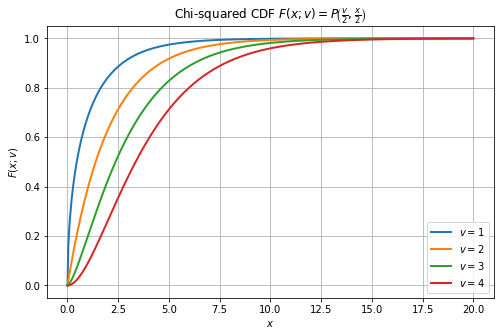

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammainc

# x-axis values
x = np.linspace(0, 20, 500)

# Degrees of freedom (v values)
v_values = [1, 2, 3, 4]

# Compute F(x; v) = P(v/2, x/2)
F = np.zeros((len(x), len(v_values)))

for i, v in enumerate(v_values):
    F[:, i] = gammainc(v / 2, x / 2)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, F, linewidth=2)

plt.grid(True)
plt.legend(
    [rf'$v = {v}$' for v in v_values],
    loc='best'
)

plt.title(
    r'Chi-squared CDF $F(x;v) = P \!\left(\frac{v}{2}, \frac{x}{2}\right)$'
)
plt.xlabel(r'$x$')
plt.ylabel(r'$F(x;v)$')

plt.show()

